## Dataset Split <a class="anchor" id="topo"></a>

In this notebook, the dataset is split into 5 parts: first, we split in pretext / downstream sets, then the pretext set in further split into training and validation, and the downstream set is split into training, validation and test. Each resulting set in then analyzed to check the balancing between classes and genders.

### Summary

* [Part 1: Notebook setup](#part_01)
* [Part 2: Dataset split](#part_02)
* [Part 3: Balancing analysis](#part_03)

### Part 1: Notebook Setup <a class="anchor" id="part_01"></a>

In this section, the necessary libraries are imported and the global variables are defined.

In [1]:
import os

import librosa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

tqdm.pandas()

PATH_TO_DATASET = "/home/lozavival/Documents/AUDIOS/datasets/release/"

print("Done!")

Done!


### Part 2: Dataframe loading and subset extraction <a class="anchor" id="part_02"></a>

In this section, the dataset csv file is loaded into a pandas dataframe and divided in 5 subsets: pretext task training and validation, and downstrean task training, validation and test.

In [ ]:
# Function to split a dataset in pretext and downstream
def split_dataset(full_df, pretext_train_percentage, pretext_val_percentage, downstream_train_percentage, downstream_val_percentage, downstream_test_percentage, random_state):
    # Split dataset in pretext and downstream
    pretext_percentage = pretext_train_percentage + pretext_val_percentage
    pretext_df, downstream_df = train_test_split(full_df, train_size=pretext_percentage, random_state=random_state)

    # Split pretext in train and val
    pretext_train_proportion = pretext_train_percentage / pretext_percentage
    pretext_train_df, pretext_val_df = train_test_split(pretext_df, train_size=pretext_train_proportion, random_state=random_state)

    # Split downstream in train, val and test
    downstream_percentage = downstream_train_percentage + downstream_val_percentage + downstream_test_percentage
    downstream_train_proportion = downstream_train_percentage / downstream_percentage
    downstream_train_df, downstream_val_test_df = train_test_split(downstream_df, train_size=downstream_train_proportion, random_state=random_state)

    downstream_val_proportion = downstream_val_percentage / (downstream_val_percentage + downstream_test_percentage)
    downstream_val_df, downstream_test_df = train_test_split(downstream_val_test_df, train_size=downstream_val_proportion, random_state=random_state)

    return pretext_train_df, pretext_val_df, downstream_train_df, downstream_val_df, downstream_test_df

# Function to split the full dataset
def split_full_dataset(dataset_path, pre_train_percentage, pre_val_percentage, down_train_percentage, down_val_percentage, down_test_percentage, random_state):
    print(f"Splitting dataset {dataset_path}...") 

    if(pre_train_percentage + pre_val_percentage + down_train_percentage + down_val_percentage + down_test_percentage != 1):
        raise Exception("Sum of pretain train and val and downstream train, val and test percentages must be equal to 1")

    # Full dataset
    full_df = pd.read_csv(dataset_path, keep_default_na=False)
    full_df = full_df.where(full_df['spoof_count'] > 0).dropna()

    # Split full dataset in male and female to make sure training datasets are balanced
    male_df   = full_df.where(full_df['gender'] == 'M').dropna()
    female_df = full_df.where(full_df['gender'] == 'F').dropna()

    # Split male and female datasets in pretext train, pretext val, downstream train, downstream val and downstream test
    male_split   = split_dataset(male_df, pre_train_percentage, pre_val_percentage, down_train_percentage, down_val_percentage, down_test_percentage, random_state)
    female_split = split_dataset(female_df, pre_train_percentage, pre_val_percentage, down_train_percentage, down_val_percentage, down_test_percentage, random_state)

    # Merge male and female split datasets
    pretext_train_df    = pd.concat([male_split[0], female_split[0]])
    pretext_val_df      = pd.concat([male_split[1], female_split[1]])
    downstream_train_df = pd.concat([male_split[2], female_split[2]])
    downstream_val_df   = pd.concat([male_split[3], female_split[3]])
    downstream_test_df  = pd.concat([male_split[4], female_split[4]])

    # Save train, val and test datasets 
    dataset_folder        = os.path.dirname(dataset_path)
    pretext_train_path    = os.path.join(dataset_folder, "pretext_train.csv")
    pretext_val_path      = os.path.join(dataset_folder, "pretext_val.csv")
    downstream_train_path = os.path.join(dataset_folder, "downstream_train.csv")
    downstream_val_path   = os.path.join(dataset_folder, "downstream_val.csv")
    downstream_test_path  = os.path.join(dataset_folder, "downstream_test.csv")
   
    print(f"Saving split datasets in {dataset_folder}...")
    pretext_train_df.to_csv(pretext_train_path, index=False)
    pretext_val_df.to_csv(pretext_val_path, index=False)
    downstream_train_df.to_csv(downstream_train_path, index=False)
    downstream_val_df.to_csv(downstream_val_path, index=False)
    downstream_test_df.to_csv(downstream_test_path, index=False)

    print("Done!")

In [ ]:
# Split the dataset

dataset_path = os.path.join(PATH_TO_DATASET, "people-meta.csv")
# Full dataset: 60% pretrain, 40% downstream
# Pretrain: 80% train, 20% val
pretext_train_percentage   = 0.6 * 0.8
pretext_val_percentage     = 0.6 * 0.2
# Downstream: 70% train, 20% val, 10% test
downstream_train_percentage = 0.4 * 0.7
downstream_val_percentage   = 0.4 * 0.2
downstream_test_percentage  = 0.4 * 0.1
random_state                = 7

split_full_dataset(dataset_path, pretext_train_percentage, pretext_val_percentage, downstream_train_percentage, downstream_val_percentage, downstream_test_percentage, random_state)

Splitting dataset /home/lozavival/Documents/AUDIOS/datasets/release/people-meta.csv...
Saving split datasets in /home/lozavival/Documents/AUDIOS/datasets/release...
Done!


### Part 3: Balancing analysis <a class="anchor" id="part_03"></a>

In this section, we make an analysis of the resulting sets to check if it is balanced in regards to class (spoof and bona-fide) and gender (male and female).

In [4]:
# Function to get the duration of an audio
def audio_duration(filename, dataset_path):
    try:
        audio_path = os.path.join(dataset_path, filename)
        y, sr = librosa.load(audio_path, sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except Exception as e:
        print(f"Could not load file {filename}: {e}")
        return None

# Function to sum the duration of all audios in a folder
def sum_audio_duration(path):
    total = 0
    folder_path = os.path.join(PATH_TO_DATASET, path)
    for filename in os.listdir(folder_path):
        total += audio_duration(filename, folder_path)
    return total / 60

In [10]:
# Function to plot the total minutes per class and gender
def plot_minutes_by_class_and_gender(data, title):
    # Reshape the data to have class and duration as separate columns
    reshaped_data = pd.melt(
        data,
        id_vars=["person", "gender"],
        value_vars=["spoof_duration", "bonafide_duration"],
        var_name="class",
        value_name="duration"
    )

    # Map the class names for clarity
    reshaped_data["class"] = reshaped_data["class"].str.replace("_duration", "")

    # Group by class and gender and sum durations
    grouped_data = reshaped_data.groupby(["class", "gender"])["duration"].sum().reset_index()

    # Create the bar plot using Seaborn
    plt.figure(figsize=(6, 6))
    sns.barplot(
        data=grouped_data,
        x='class',  # Group by class
        y='duration',  # Total duration in minutes
        hue='gender',  # Separate bars by gender
        palette={'M': 'royalblue', 'F': 'tomato'}
    )

    # Customize the plot
    plt.title(f"Total Minutes per Class and Gender - {title}", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Total Duration (Minutes)", fontsize=12)
    plt.legend(title="Gender")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
# Load the split datasets

pretext_train_df = pd.read_csv(os.path.join(PATH_TO_DATASET, "pretext_train.csv"), keep_default_na=False)
pretext_val_df = pd.read_csv(os.path.join(PATH_TO_DATASET, "pretext_val.csv"), keep_default_na=False)
downstream_train_df = pd.read_csv(os.path.join(PATH_TO_DATASET, "downstream_train.csv"), keep_default_na=False)
downstream_val_df = pd.read_csv(os.path.join(PATH_TO_DATASET, "downstream_val.csv"), keep_default_na=False)
downstream_test_df = pd.read_csv(os.path.join(PATH_TO_DATASET, "downstream_test.csv"), keep_default_na=False)

In [5]:
# Calculate the total duration of each class for person in each dataset

print("Pretext train dataset:")
pretext_train_df["spoof_duration"] = pretext_train_df["spoof_path"].progress_apply(sum_audio_duration)
pretext_train_df["bonafide_duration"] = pretext_train_df["bonafide_path"].progress_apply(sum_audio_duration)

print("Pretext val dataset:")
pretext_val_df["spoof_duration"] = pretext_val_df["spoof_path"].progress_apply(sum_audio_duration)
pretext_val_df["bonafide_duration"] = pretext_val_df["bonafide_path"].progress_apply(sum_audio_duration)

print("Downstream train dataset:")
downstream_train_df["spoof_duration"] = downstream_train_df["spoof_path"].progress_apply(sum_audio_duration)
downstream_train_df["bonafide_duration"] = downstream_train_df["bonafide_path"].progress_apply(sum_audio_duration)

print("Downstream val dataset:")
downstream_val_df["spoof_duration"] = downstream_val_df["spoof_path"].progress_apply(sum_audio_duration)
downstream_val_df["bonafide_duration"] = downstream_val_df["bonafide_path"].progress_apply(sum_audio_duration)

print("Downstream test dataset:")
downstream_test_df["spoof_duration"] = downstream_test_df["spoof_path"].progress_apply(sum_audio_duration)
downstream_test_df["bonafide_duration"] = downstream_test_df["bonafide_path"].progress_apply(sum_audio_duration)

print("Done!")

Pretext train dataset:


100%|██████████| 42/42 [00:33<00:00,  1.26it/s]


Pretext val dataset:


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


Downstream train dataset:


100%|██████████| 25/25 [00:21<00:00,  1.16it/s]


Downstream val dataset:


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Downstream test dataset:


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

Done!


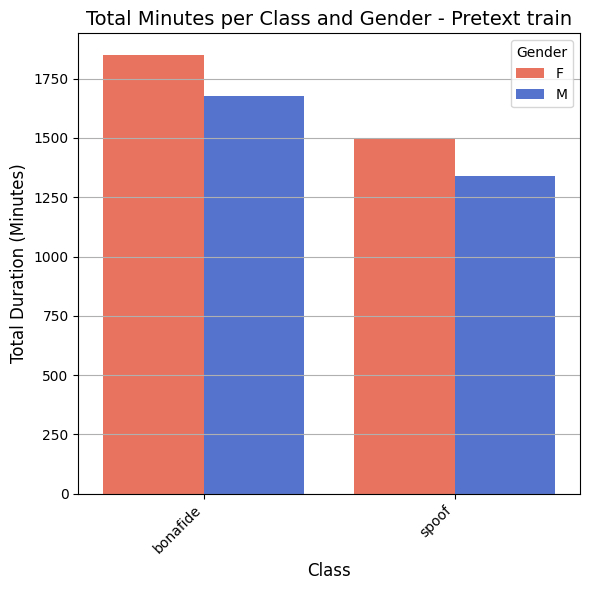

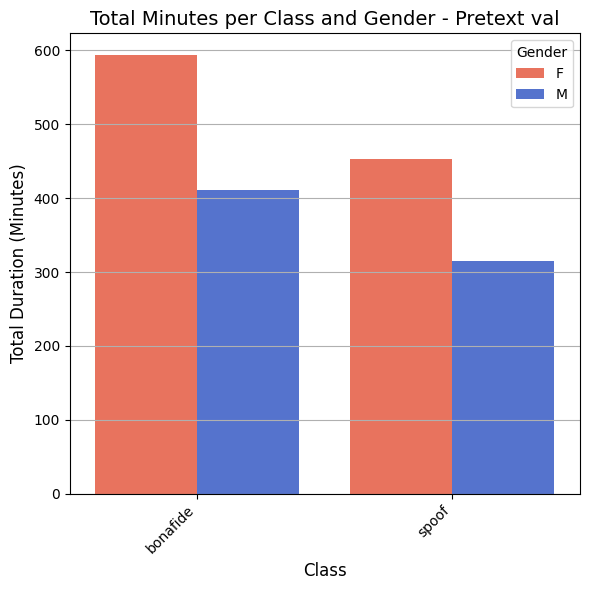

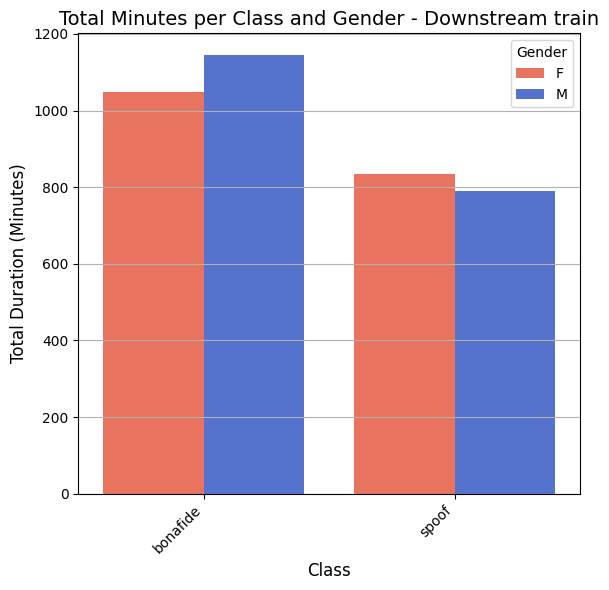

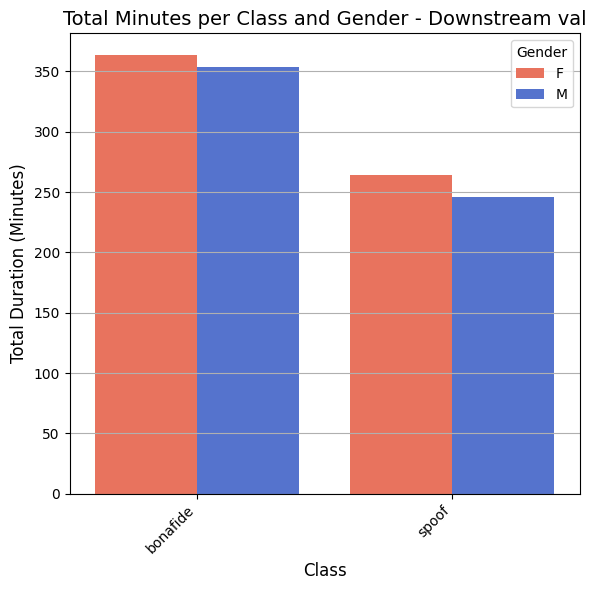

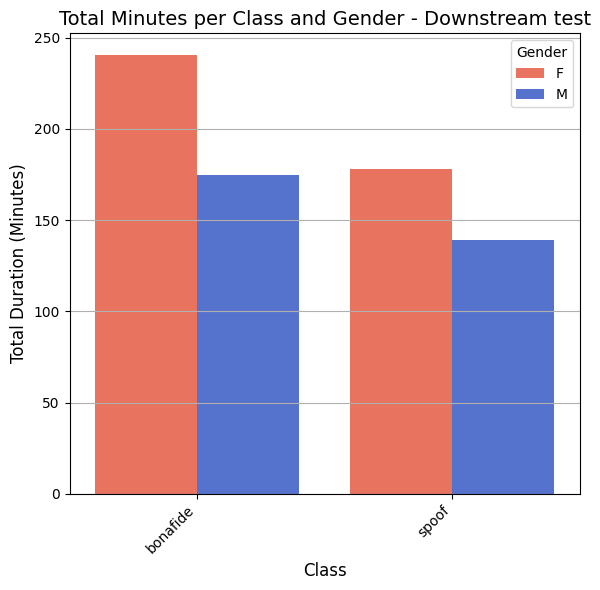

In [11]:
# Plot the barcharts for each dataset

plot_minutes_by_class_and_gender(pretext_train_df, "Pretext train")
plot_minutes_by_class_and_gender(pretext_val_df, "Pretext val")
plot_minutes_by_class_and_gender(downstream_train_df, "Downstream train")
plot_minutes_by_class_and_gender(downstream_val_df, "Downstream val")
plot_minutes_by_class_and_gender(downstream_test_df, "Downstream test")

[Voltar ao topo](#topo)